In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/data/Raman

/content/drive/MyDrive/data/Raman


In [ ]:
import re
import os
import json
import numpy as np
import pandas as pd
import torch
import random
import pickle
from torch.utils.data import Dataset, DataLoader

In [ ]:
ls

 Acephate_dataset.npy                    __pycache__/
 Acephate_Exported.dat                   resnet.py
 Acetamiprid_dataset.npy                 RRUFF/
 analyte_peaks.pickle                    shelve_save_data_analyte.out.bak
 analytes_peak_chosen_ones_dict.pickle   shelve_save_data_analyte.out.dat
 analytes_peaks_dict.json                shelve_save_data_analyte.out.dir
 area1_Exported.dat                      shelve_save_data.out.bak
 Carbendazim_dataset.npy                 shelve_save_data.out.dat
 config.py                               shelve_save_data.out.dir
 datasets.py                             spectral_data_not_norm.csv
 finetuned_best.ckpt                     spectral_data_rb.csv
 finetuned.ckpt                         'spectroscopy code to do.gdoc'
 finetuned_raman_5.ckpt                  spectrum_data.csv
 Imidacloprid_dataset.npy                Synthetic_Signal.py
 MG_dataset.npy                          Thiacloprid_dataset.npy
 nice_peak.png                           

In [ ]:
files = sorted(os.listdir('RRUFF/raman'))

In [ ]:
# Opening JSON file
f = open('RRUFF/labels.json',)
   
# returns JSON object as 
# a dictionary
analytes = json.load(f)
   
# Iterating through the json
# list
for i in analytes:
    print(i)
  
# Closing file
f.close()

Abelsonite
Abhurite
Abramovite
Acanthite
Actinolite
Adamite
AdamsiteY
Adanite
Adelite
Aegirine
Aenigmatite
Aerinite
AeschyniteY
Afghanite
Afmite
Afwillite
AgarditeY
Agrellite
Aheylite
Ahlfeldite
Aikinite
Ajoite
Akatoreite
Akermanite
Akrochordite
AlSO4OH
Alabandite
Alacranite
Alamosite
Albite
Aldermanite
Aleksite
Alforsite
Allabogdanite
Allactite
AllaniteCe
AllaniteLa
Allanpringite
Alleghanyite
Alloclasite
Allophane
Alloriite
Alluaudite
Almandine
Alstonite
Altaite
Alterite
Althausite
AlumK
AlumNa
Aluminite
Aluminium
Alumohydrocalcite
Alumoklyuchevskite
Alunite
Alunogen
Amarantite
Amber
Amblygonite
Ameghinite
Amesite
Amicite
Aminoffite
Ammineite
Ammonioalunite
Ammoniojarosite
Ammonioleucite
Ammoniomathesiusite
Amphibole
Analcime
Anapaite
Anatase
AncyliteCe
Andalusite
Andersonite
Andesine
AndoriteVI
Andradite
Anglesite
Anhydrite
Anilite
Ankerite
Ankinovichite
Annabergite
Annite
Anorpiment
Anorthite
Anthoinite
Anthophyllite
Anthraxolite
Antigorite
Antimony
Antipinite
Antlerite
Apachite
Aph

In [ ]:
print(files[0])
files[0].split('_')

In [ ]:
dataset_dict={}

In [ ]:
count = 0
dataset_dict = {}
for analyte in sorted(list(analytes.keys())):
  words = [analyte, 'Processed']
  # print(analyte)
  for _file_ in files:
    # print(_file_)
    stringlist = _file_.split('_')
    if words[0] in stringlist and words[1] in stringlist:
      print('analyte: {}, filename: {} \n'.format(analyte, _file_))
      if analyte not in dataset_dict:
        print('analyte not in dataset')
        print(analyte)
        # print(dataset_dict[analyte])
        dataset_dict[analyte] = [_file_]
      else:
        print('analyte in dataset')
        print(analyte)
        print(dataset_dict[analyte])
        dataset_dict[analyte].append(_file_)

In [ ]:
dataset_dict

In [ ]:
with open('dataset_dict.json', 'w') as fp:
    json.dump(dataset_dict, fp)

In [ ]:
# Opening JSON file
f = open('RRUFF/dataset_dict.json',)
   
# returns JSON object as 
# a dictionary
dataset_dict = json.load(f)
   
# Iterating through the json
# list
for i in dataset_dict:
    print(i)
  
# Closing file
f.close()

Abelsonite
Abhurite
Abramovite
Acanthite
Actinolite
Adamite
AdamsiteY
Adanite
Adelite
Aegirine
Aenigmatite
Aerinite
AeschyniteY
Afghanite
Afmite
Afwillite
AgarditeY
Agrellite
Aheylite
Ahlfeldite
Aikinite
Ajoite
Akatoreite
Akermanite
Akrochordite
AlSO4OH
Alabandite
Alacranite
Alamosite
Albite
Aldermanite
Aleksite
Alforsite
Allabogdanite
Allactite
AllaniteCe
AllaniteLa
Allanpringite
Alleghanyite
Alloclasite
Allophane
Alloriite
Alluaudite
Almandine
Alstonite
Alterite
Althausite
AlumK
AlumNa
Aluminite
Aluminium
Alumohydrocalcite
Alumoklyuchevskite
Alunite
Alunogen
Amarantite
Amber
Amblygonite
Ameghinite
Amesite
Amicite
Aminoffite
Ammineite
Ammonioalunite
Ammoniojarosite
Ammonioleucite
Ammoniomathesiusite
Amphibole
Analcime
Anapaite
Anatase
AncyliteCe
Andalusite
Andersonite
Andesine
AndoriteVI
Andradite
Anglesite
Anhydrite
Anilite
Ankerite
Ankinovichite
Annabergite
Annite
Anorpiment
Anorthite
Anthoinite
Anthophyllite
Antigorite
Antimony
Antipinite
Antlerite
Apachite
Aphthitalite
Apjohnite
A

In [ ]:
print(len(list(dataset_dict.keys())))
print(len(list(analytes.keys())))

2259
2275


In [ ]:
labels = {}
for index, line in enumerate(files):
    mineral_name = re.findall('[^_]*', line)[0]
    if mineral_name in labels:
        labels[mineral_name][1] += 1
    else:
        labels[mineral_name] = [index, 0]

In [ ]:
with open('labels.json', 'w') as fp:
        json.dump(labels, fp,  indent=4)

In [ ]:
def peakdet(v, delta, x=None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html

    Returns two arrays

    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.

    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.

    """
    maxtab = []
    mintab = []

    if x is None:
        x = np.arange(len(v))

    v = np.asarray(v)

    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')

    if not np.isscalar(delta):
        sys.exit('Input argument delta must be a scalar')

    if delta <= 0:
        sys.exit('Input argument delta must be positive')

    mn, mx = np.Inf, -np.Inf
    mnpos, mxpos = np.NaN, np.NaN

    lookformax = True

    for i in np.arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]

        if lookformax:
            if this < mx - delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn + delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return np.array(maxtab), np.array(mintab)

In [ ]:
dataset_list = []
for index, filename in enumerate(files):
    tmp = pd.read_csv('RRUFF/raman/' + filename, sep=',', comment='#', header=None)  
    dataset_list.append(np.array(tmp.iloc[:, 1], dtype=np.float64))
    if index % 100 == 0:
      print(index // 100)

In [ ]:
len(files)

36965

In [ ]:
check = pd.read_csv('RRUFF/raman/' + files[random.randint(0, 36964)], sep=',', comment='#', header=None)
wavenumber = np.array(check.iloc[:, 0], dtype=np.float64)
spectra = np.array(check.iloc[:, 1], dtype=np.float64)
print(type(check.iloc[:, 1]))

<class 'pandas.core.series.Series'>


In [ ]:
maxtab, mintab = peakdet(spectra / np.max(spectra), 0.08)

In [ ]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(15, 10))
# plt.plot(spectra)
# plt.scatter(np.array(maxtab)[:,0], np.array(maxtab)[:,1] * np.max(spectra), color='blue')
# # plt.scatter(np.array(mintab)[:,0], np.array(mintab)[:,1], color='red')
plt.savefig('nice_peak.png', dpi=600)

<Figure size 432x288 with 0 Axes>

In [ ]:
print(wavenumber.shape)
print(spectra.shape)

NameError: ignored

In [ ]:
path = 'RRUFF/raman/'
analytes_peak_chosen_ones_dict = {}
count = 0
pos = []
for index, analyte in enumerate(list(dataset_dict.items())):
  if len(analyte[1]) > 20:
    count += 1
    pos.append(index)
    # # print(len(i[1]))
    # for filename in analyte[1]:
    #   tmp = pd.read_csv(path + filename, sep=',', comment='#', header=None)
    #   wavenumber = np.array(tmp.iloc[:, 0], dtype=np.float64)
    #   spectra = np.array(tmp.iloc[:, 1], dtype=np.float64)
    #   maxtab, mintab = peakdet(spectra / np.max(spectra), 0.07, wavenumber)
    #   if analyte[0] not in analytes_peak_chosen_ones_dict:
    #     print('analyte not in dataset')
    #     print(analyte)
    #     # print(dataset_dict[analyte])
    #     if maxtab.ndim > 1 and mintab.ndim > 1:
    #       analytes_peak_chosen_ones_dict[analyte[0]] = [(filename, maxtab)]
    #   else:
    #     print('analyte in dataset')
    #     print(analyte)
    #     if maxtab.ndim > 1 and mintab.ndim > 1:
    #       analytes_peak_chosen_ones_dict[analyte[0]].append((filename, maxtab))
print(count)

161


In [ ]:
print(list(dataset_dict.items()))

[('Abelsonite', ['Abelsonite__R070007__Raman__532__0__unoriented__Raman_Data_Processed__27040.txt', 'Abelsonite__R070007__Raman__785__0__unoriented__Raman_Data_Processed__25958.txt']), ('Abhurite', ['Abhurite__R060227__Raman__532__0__unoriented__Raman_Data_Processed__33408.txt', 'Abhurite__R060227__Raman__780__0__unoriented__Raman_Data_Processed__33410.txt']), ('Abramovite', ['Abramovite__R070037__Broad_Scan__532__0__unoriented__Raman_Data_Processed__16937.txt', 'Abramovite__R070037__Raman__532__0__unoriented__Raman_Data_Processed__25038.txt']), ('Acanthite', ['Acanthite__R070578__Broad_Scan__532__0__unoriented__Raman_Data_Processed__17614.txt', 'Acanthite__R070578__Broad_Scan__780__0__unoriented__Raman_Data_Processed__17615.txt', 'Acanthite__R070578__Raman__532__0__unoriented__Raman_Data_Processed__23032.txt', 'Acanthite__R070578__Raman__780__0__unoriented__Raman_Data_Processed__28322.txt']), ('Actinolite', ['Actinolite__R040063-3__Raman__514__0__ccw__Raman_Data_Processed__31130.txt',

In [ ]:
import math
from scipy.signal import savgol_filter

In [ ]:
path = 'RRUFF/raman/'
analytes_peak_chosen_ones_dict = {}
for index, analyte in enumerate(list(dataset_dict.items())):
  if len(analyte[1]) > 20:
    # print(len(i[1]))
    snr = []
    for filename in analyte[1]:
      tmp = pd.read_csv(path + filename, sep=',', comment='#', header=None)
      spectra = np.array(tmp.iloc[:, 1], dtype=np.float64)
      ref_quality = savgol_filter(spectra, 9, 3)
      tmp_snr = 10 * math.log10(np.sum(np.abs(spectra) ** 2) / np.sum(np.abs(ref_quality - spectra) ** 2))
      snr.append(tmp_snr)
    
    index_highest_snr = snr.index(max(snr))
    print(analyte[1][index_highest_snr])
    tmp = pd.read_csv(path + analyte[1][index_highest_snr], sep=',', comment='#', header=None)
    spectra = np.array(tmp.iloc[:, 1], dtype=np.float64)
    wavenumber = np.array(tmp.iloc[:, 0], dtype=np.float64)
    maxtab, mintab = peakdet(spectra / np.max(spectra), 0.07, wavenumber)
    analytes_peak_chosen_ones_dict[analyte[0]] = [(analyte[1][index_highest_snr], maxtab)]

Actinolite__R050336__Broad_Scan__532__0__unoriented__Raman_Data_Processed__17954.txt
Adamite__R040130__Broad_Scan__532__0__unoriented__Raman_Data_Processed__18614.txt
Aegirine__R061093__Raman__785__0__unoriented__Raman_Data_Processed__15973.txt
Aenigmatite__R061088-5__Raman__514__45__ccw__Raman_Data_Processed__29366.txt
Albite__R060054__Raman__532__0__unoriented__Raman_Data_Processed__26970.txt
Almandine__R060099__Raman__532__0__unoriented__Raman_Data_Processed__28565.txt
Amblygonite__R040006__Raman__532__0__unoriented__Raman_Data_Processed__14787.txt
Analcime__R120095__Raman__780__0__unoriented__Raman_Data_Processed__36634.txt
Andalusite__R050258__Broad_Scan__532__0__unoriented__Raman_Data_Processed__19622.txt
Andradite__R060326__Broad_Scan__532__0__unoriented__Raman_Data_Processed__19606.txt
Anglesite__R040004__Raman__780__0__unoriented__Raman_Data_Processed__26203.txt
Anhydrite__R040012__Raman__780__0__unoriented__Raman_Data_Processed__26320.txt
Ankerite__R050197__Raman__532__0__uno

In [ ]:
import pickle

with open('analytes_peak_chosen_ones_dict.pickle', 'wb') as handle:
    pickle.dump(analytes_peak_chosen_ones_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def choose_files(dataset_dict):
analytes_peak_chosen_ones_dict = {}
  for index, analyte in enumerate(list(dataset_dict.items())):
  if len(analyte[1]) > 20:
    # print(len(i[1]))
    snr = []
    for filename in analyte[1]:
      tmp = pd.read_csv(path + filename, sep=',', comment='#', header=None)
      spectra = np.array(tmp.iloc[:, 1], dtype=np.float64)
      ref_quality = savgol_filter(spectra, 9, 3)
      tmp_snr = 10 * math.log10(np.sum(np.abs(spectra) ** 2) / np.sum(np.abs(ref_quality - spectra) ** 2))
      snr.append(tmp_snr)
    
    index_highest_snr = snr.index(max(snr))
    print(analyte[1][index_highest_snr])
    tmp = pd.read_csv(path + analyte[1][index_highest_snr], sep=',', comment='#', header=None)
    spectra = np.array(tmp.iloc[:, 1], dtype=np.float64)
    wavenumber = np.array(tmp.iloc[:, 0], dtype=np.float64)
    analytes_peak_chosen_ones_dict[analyte[0]] = [(analyte[1][index_highest_snr], maxtab)]
      # if analyte[0] not in analytes_peak_chosen_ones_dict:
      #   print('analyte not in dataset')
      #   print(analyte)
      #   # print(dataset_dict[analyte])
      #   if maxtab.ndim > 1 and mintab.ndim > 1:
      #     analytes_peak_chosen_ones_dict[analyte[0]] = [(filename, maxtab)]
      # else:
      #   print('analyte in dataset')
      #   print(analyte)
      #   if maxtab.ndim > 1 and mintab.ndim > 1:
      #     analytes_peak_chosen_ones_dict[analyte[0]].append((filename, maxtab))

In [ ]:
path = 'RRUFF/raman/'
count = 0
analytes_peaks_dict = {}
for analyte in list(dataset_dict.items()):
  for filename in analyte[1]:
    tmp = pd.read_csv(path + filename, sep=',', comment='#', header=None)
    # wavenumber = np.array(tmp.iloc[:, 0], dtype=np.float64)
    spectra = np.array(tmp.iloc[:, 1], dtype=np.float64)
    maxtab, mintab = peakdet(spectra / np.max(spectra), 0.08)
    if analyte[0] not in analytes_peaks_dict:
      print('analyte not in dataset')
      print(analyte)
      # print(dataset_dict[analyte])
      if maxtab.ndim > 1 and mintab.ndim > 1:
        analytes_peaks_dict[analyte[0]] = [(filename, maxtab[:, 1] * np.max(spectra), mintab[:, 1] * np.max(spectra))]
    else:
      print('analyte in dataset')
      print(analyte)
      if maxtab.ndim > 1 and mintab.ndim > 1:
        analytes_peaks_dict[analyte[0]].append((filename, maxtab[:, 1] * np.max(spectra), mintab[:, 1] * np.max(spectra)))

In [ ]:
import pickle

with open('analyte_peaks.pickle', 'wb') as handle:
    pickle.dump(analytes_peaks_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

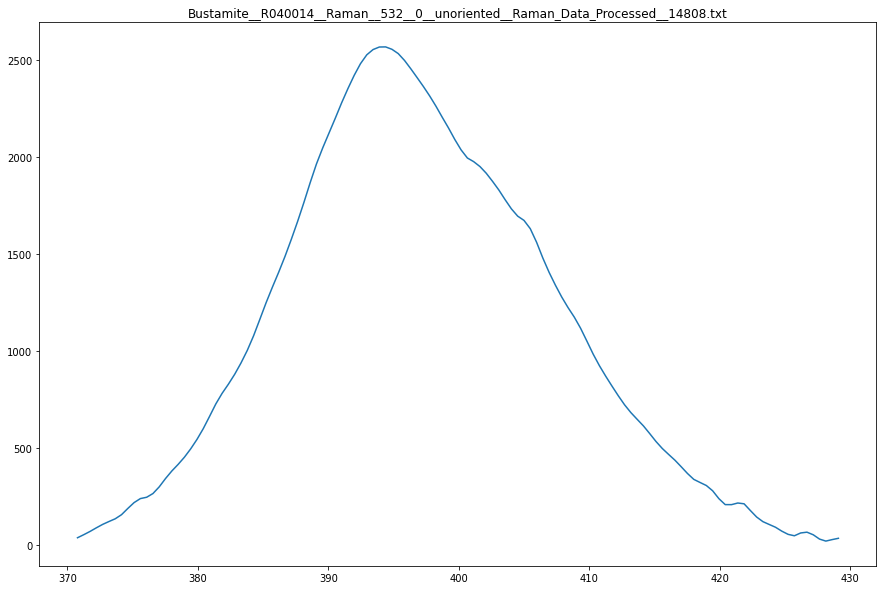

In [ ]:
import pickle 
import os
import pandas as pd
import numpy as np

path = 'RRUFF/raman/'
with open('analytes_peak_chosen_ones_dict.pickle', 'rb') as handle:
    dataset_dict_new = pickle.load(handle)

files_to_check = []
analytes = list(dataset_dict_new.keys())[0:]
wavenumbers = []
spectras = []
peaks = []
for item in analytes:
  filename = dataset_dict_new[item][0][0]
  tmp_peaks = dataset_dict_new[item][0][1]
  check = pd.read_csv(path + filename, sep=',', comment='#', header=None)
  wavenumber = np.array(check.iloc[:, 0], dtype=np.float64)
  spectra = np.array(check.iloc[:, 1], dtype=np.float64)
  wavenumbers.append(wavenumber)
  spectras.append(spectra)
  peaks.append(tmp_peaks)
  files_to_check.append(filename)



import matplotlib.pyplot as plt
index = 31
begin = 525
end = 647
# print(np.where(wavenumbers[index] >= 380))
# print(np.where(wavenumbers[index] <= 420))
plt.figure(figsize=(15, 10))
# plt.plot(wavenumbers[index], spectras[index])
plt.plot(wavenumbers[index][begin:end], spectras[index][begin:end])
# plt.scatter(np.array(peaks[index])[:,0], np.array(peaks[index])[:,1] * np.max(spectras[index]), color='blue')
plt.title(files_to_check[index])
plt.show()

In [ ]:
path = 'RRUFF/raman/'
count = 0
analytes_peaks_wavenumber_dict = {}
for analyte in list(dataset_dict.items()):
  for filename in analyte[1]:
    tmp = pd.read_csv(path + filename, sep=',', comment='#', header=None)
    # wavenumber = np.array(tmp.iloc[:, 0], dtype=np.float64)
    spectra = np.array(tmp.iloc[:, 1], dtype=np.float64)
    maxtab, mintab = peakdet(spectra / np.max(spectra), 0.08)
    if analyte[0] not in analytes_peaks_dict:
      print('analyte not in dataset')
      print(analyte)
      # print(dataset_dict[analyte])
      if maxtab.ndim > 1 and mintab.ndim > 1:
        analytes_peaks_wavenumber_dict[analyte[0]] = [(filename, maxtab[:, 1] * np.max(spectra), mintab[:, 1] * np.max(spectra))]
    else:
      print('analyte in dataset')
      print(analyte)
      if maxtab.ndim > 1 and mintab.ndim > 1:
        analytes_peaks_wavenumber_dict[analyte[0]].append((filename, maxtab[:, 1] * np.max(spectra), mintab[:, 1] * np.max(spectra)))

46.750217187488204


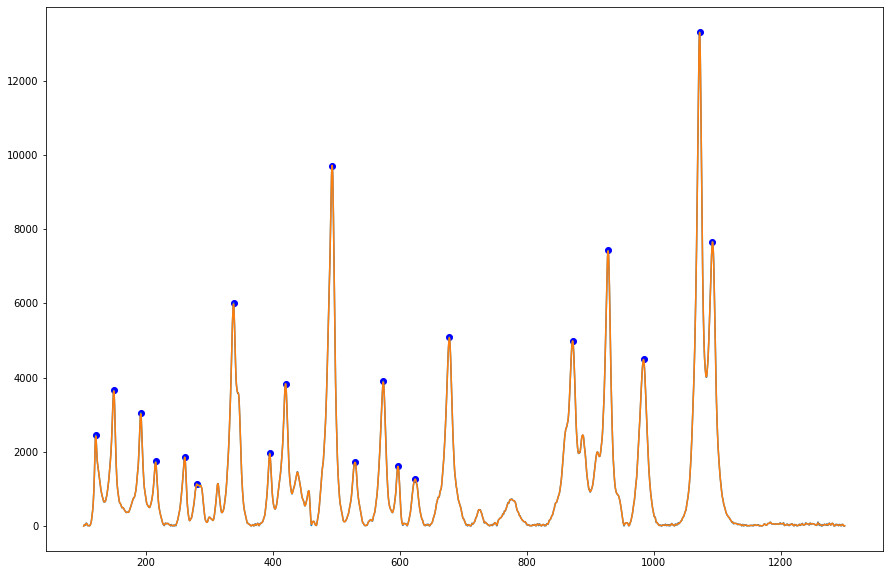

In [ ]:
# filename = files[random.randint(0, len(files))]
filename = 'Zoisite__X060001__Raman__532__0__unoriented__Raman_Data_Processed__13166.txt'
check = pd.read_csv('RRUFF/raman/' + filename, sep=',', comment='#', header=None)
wavenumber = np.array(check.iloc[:, 0], dtype=np.float64)
spectra = np.array(check.iloc[:, 1], dtype=np.float64)
ref_quality = savgol_filter(spectra, 9, 3)
tmp_snr = 10 * math.log10(np.sum(np.abs(spectra) ** 2) / np.sum(np.abs(ref_quality - spectra) ** 2))
# snr.append(spectra / (ref_quality - spectra))
print(tmp_snr)
# print(sndr_mean / len(spectra))

maxtab, mintab = peakdet(spectra / np.max(spectra), 0.07, wavenumber)

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.plot(wavenumber, spectra)
plt.plot(wavenumber, ref_quality)
plt.scatter(np.array(maxtab)[:,0], np.array(maxtab)[:,1] * np.max(spectra), color='blue')
# plt.scatter(np.array(mintab)[:,0], np.array(mintab)[:,1] * np.max(spectra), color='red')
plt.show()

In [ ]:
def find_peak_supp(int_idx, y_data, peak_importance_fun, discount=0.85):
    
    # int_idx
    #  -> left and right edges
    # y_data
    #  -> spectral data 
    # back_data
    #  -> spectral data 
    # discount=0.85
    #  -> how generous we are in getting the peaks to continue
    #  
    
    # SR: debug

    # int_idx=idx_lr_tmp
    
    # define the steppeness an the mse of the diff of the 
    
    # expand left and right until the steepness in         
    
    # TODO
    # checknig for teh boundaries "should" be unnecessary 
    
    res=len(y_data)
    
    l_pos_temp=int(np.max([int_idx[0],0]))
    r_pos_temp=int(np.min([int_idx[1],res-1]))
    
    # extend the peak until the decrease from the max importance you have seen in the window is discont*max
    # 
    max_impo = peak_importance_fun(y_data[range(int_idx[0],int_idx[1])])
    
    # expand the interval until is decreasing by a factor discount, discount account for the randomness in the error
    # the discount starts from the median of the vector
    
    expand_left = True
    expand_right = True
    
    while expand_left == True or expand_right == True:
        
        # check boundariens

        if l_pos_temp==0:
           expand_left=False
           
        if r_pos_temp==res-1:
            expand_right = False
            
        
        if expand_left == True:            
            impo_left = peak_importance_fun(y_data[range(l_pos_temp-1,r_pos_temp)])
                                            
            if impo_left < discount*max_impo:
               expand_left=False     
            else :
               l_pos_temp=l_pos_temp-1
               
        if expand_right == True:
            impo_rigth=peak_importance_fun(y_data[range(l_pos_temp,r_pos_temp+1)])
            
            if impo_rigth< discount*max_impo : 
               expand_left=False     
            else :
               r_pos_temp=r_pos_temp+1
            
        
        # update max importance
        # TODO we can do this better?
        tmp_impo = peak_importance_fun(y_data[range(l_pos_temp,r_pos_temp)])
        
        if tmp_impo > max_impo:
            max_impo=tmp_impo 
        
    return [l_pos_temp,r_pos_temp]


In [ ]:
with open('analytes_peaks_dict.json', 'w') as fp:
    json.dump(analytes_peaks_dict, fp)

NameError: ignored

In [ ]:
class RRUFFSpectraDataset(Dataset):
    def __init__(self, labels, spectra_dir, transform=None, target_transform=None):
        self.spectra_labels = json.load(labels)
        self.spectra_dir = spectra_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.spectra_labels)

    def __getitem__(self, idx):
        spectra_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label